<a href="https://colab.research.google.com/github/DreamTeamInc/Core-DS/blob/issues%2F6/research/day/FCN_semantic_segmentation_model_Leon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Команда ниже монтирует образ gDrive. Добавь ярлык на папку с керном перед этим.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to 'sample_core_analysis_data_example' folder with folder name
SAMPLE_CORE_PATH = 'drive/My Drive/ sample_core_analysis_data_example'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install pytorch-lightning
# !pip install imgaug==0.4.0

# Инициализация библиотек

Для предобработки информации

In [ ]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
from skimage import io

pd.options.mode.chained_assignment = None

Для обучения нейронной сети

In [ ]:
from __future__ import print_function, division
import os
import time
import torch
import pandas as pd
from skimage import io, transform, img_as_float32, img_as_ubyte
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn import  metrics
import imgaug.augmenters as iaa

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Фиксация сидов для воспроизводимости результатов

In [ ]:
import random
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Предобработка данных

In [ ]:
data = pd.read_csv(SAMPLE_CORE_PATH + '/data.csv')
data = data[data['photo_type'] == 'ДС']
data_trash = data[data['segment_value'] == 'Переслаивание пород']

for photo_id in data_trash['photo_id']:
    data = data[data['photo_id'] != photo_id]

data.drop(['photo_type'], axis=1, inplace=True)
print(data.shape)
print(data['photo_id'].unique().shape)
data.head(3)

(6181, 5)
(548,)


,task_id,photo_id,segment_num,segment_type,segment_value
473,af172321_d549_42e7_8d2c_e7515a7f8eae,1013300,0,Порода,Глинисто-кремнистая порода
474,af172321_d549_42e7_8d2c_e7515a7f8eae,1013300,1,Разрушенность,Разлом
475,af172321_d549_42e7_8d2c_e7515a7f8eae,1013300,2,Порода,Глинисто-кремнистая порода


In [ ]:
def show_image(image):
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.imshow(image)
    ax.axis('off')
    return fig, ax

def get_photo(data, i):
    return io.imread(SAMPLE_CORE_PATH + '/photos/{}.jpeg'.format(data['photo_id'].iloc[i]))

def get_mask(data, i):
    return np.load(SAMPLE_CORE_PATH + '/matrixes/matrix_{}__{}.npz'.format(data['photo_id'].iloc[i], data['task_id'].iloc[i]))['data']

def get_json(data, i):
    datastore = ''
    with open(SAMPLE_CORE_PATH + '/extra/extra_{}__{}.json'.format(data['photo_id'].iloc[i],
                                                                   data['task_id'].iloc[i]), 'r', encoding="utf8") as f:
        datastore = json.load(f)

    return datastore

def show_all(data, i):
    print(data.iloc[i])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
    ax1.imshow(get_photo(data, i))
    ax1.axis('off')

    cmap = plt.get_cmap('tab20b', np.max(get_mask(data, i)) + 1)
    mask = ax2.imshow(get_mask(data, i), cmap=cmap,
                      vmin=-0.5, vmax=np.max(get_mask(data, i))+0.5)
    ax2.axis('off')
    fig.colorbar(mask, ticks=np.arange(0, np.max(get_mask(data, i))+1))
    return fig, (ax1, ax2)



def show_photo_seies(data, column, value):
    fig, ax_ar = plt.subplots(1, 5, figsize=(14, 14))
    filt_data = data[data[column] == value]
    i = np.random.randint(0, filt_data.shape[0])
    for ax in ax_ar:
        filt_by_photo = filt_data[filt_data['photo_id'] == filt_data['photo_id'].iloc[i]]
        segments = filt_by_photo['segment_num'].values
        photo = get_photo(filt_data, i)
        mask = get_mask(filt_data, i)
        for value in segments:
            mask = np.ma.masked_where(mask == value, mask)
        
        ax.imshow(photo)
        ax.imshow(mask)
        ax.axis('off')
        filt_data.drop(filt_by_photo.index.values, axis=0, inplace=True)
        i = np.random.randint(0, filt_data.shape[0])
    
    return fig, ax_ar

def calculate_mean_and_std(data):
    mean = (0, 0, 0)
    std = (0, 0, 0)

    for i in range(len(data)):
        photo = img_as_float32(get_photo(data, i))
        mean += np.mean(photo, axis=(0,1))
        std += np.std(photo, axis=(0,1))

        if(i % 50 == 0):
            print(i)
    
    mean /= len(data)
    std /= len(data)

    print('mean RGB : ', mean)
    print('std RGB : ', std)

Выбираем фото, сделанные на дневном свете и сопоставляем каждому сегменты разбитые по типу сегмента.

In [ ]:
def get_photo_df(data):
    df = pd.DataFrame(data=data['photo_id'].unique(), columns=['photo_id'])
    
    df['task_id'] = ''
    for i in range(df.shape[0]):
        task_id = data[data['photo_id'] == df['photo_id'].iloc[i]]['task_id'].iloc[0]
        df['task_id'].iloc[i] = task_id

    for value in data['segment_value']:
        df[value] = ''

    for i in range(df.shape[0]):
        data_ph = data[data['photo_id'] == df['photo_id'].iloc[i]]

        for value in data_ph['segment_value']:
            data_seg = data_ph[data_ph['segment_value'] == value]
            seg_nums = data_seg['segment_num'].to_numpy()
            df[value].iloc[i] = seg_nums

    df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    return df

df = get_photo_df(data)
print(df.shape)
df.head(3)

(548, 14)


,photo_id,task_id,Глинисто-кремнистая порода,Разлом,Аргиллит,Алевролит глинистый,Песчаник,Песчаник глинистый,Проба,Уголь,Аргиллит углистый,Алевролит,Карбонатная порода,Известняк
0,1013300,af172321_d549_42e7_8d2c_e7515a7f8eae,"[0, 2, 4, 6]","[1, 3, 5, 7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1006688,b8e02fee_f425_4102_a9fb_67903c2e0fb0,NaN,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 28, 46, 52, 62]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1012506,d61a735f_b840_426f_aead_8d087b469f58,NaN,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",NaN,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количественное распределение классов по фотографиям

In [ ]:
df.notna().sum()

photo_id                      548
task_id                       548
Глинисто-кремнистая порода      4
Разлом                        482
Аргиллит                      211
Алевролит глинистый            74
Песчаник                      259
Песчаник глинистый             36
Проба                          32
Уголь                           4
Аргиллит углистый               6
Алевролит                       5
Карбонатная порода              5
Известняк                       1
dtype: int64

In [ ]:
df_filt = df.copy()
df_filt = df_filt[df_filt['Известняк'].isna()]
df_filt.drop(['Известняк'], axis=1, inplace=True)
print(df_filt.shape)
df_filt.head(3)

(547, 13)


,photo_id,task_id,Глинисто-кремнистая порода,Разлом,Аргиллит,Алевролит глинистый,Песчаник,Песчаник глинистый,Проба,Уголь,Аргиллит углистый,Алевролит,Карбонатная порода
0,1013300,af172321_d549_42e7_8d2c_e7515a7f8eae,"[0, 2, 4, 6]","[1, 3, 5, 7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1006688,b8e02fee_f425_4102_a9fb_67903c2e0fb0,NaN,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[3, 28, 46, 52, 62]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1012506,d61a735f_b840_426f_aead_8d087b469f58,NaN,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",NaN,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_filt.notna().sum()

photo_id                      547
task_id                       547
Глинисто-кремнистая порода      4
Разлом                        481
Аргиллит                      210
Алевролит глинистый            74
Песчаник                      259
Песчаник глинистый             36
Проба                          32
Уголь                           4
Аргиллит углистый               6
Алевролит                       5
Карбонатная порода              5
dtype: int64

## Реализация перечисляемого типа, отвечающего за сегменты, которые будет распознавать модель

In [ ]:
from enum import Enum

class Segments(Enum):
#    Разлом = 0
#    Проба = 1
#    Глинистоtкремнистая_порода = 2
   Аргиллит = 0
   Алевролит_глинистый = 1
   Песчаник = 2
#    Песчаник_глинистый = 6
#    Уголь = 7
#    Аргиллит_углистый = 8
#    Алевролит = 9
#    Карбонатная_порода = 10
   Другое = 3


## Фильтрация датасета по Segments и формирование тренировочной и валидационной выборок

In [ ]:
def make_train_val(df):
    df_train = pd.DataFrame(columns=df.columns)
    df_val = pd.DataFrame(columns=df.columns)

    for name, member in Segments.__members__.items():
        name = name.replace('_', ' ').replace('t','-')
        if name == 'Другое' or name == 'Проба' or name == 'Разлом':
            continue
        if df[name].notna().sum() > 3:
            df_col = df[df[name].notna()]
            
            if len(df_col) > 74:
                df_col = df_col.sample(75) 
            for i in range(len(df_col)*2//5):
                if not df_col['photo_id'].iloc[i] in df_train.photo_id: 
                    df_train = df_train.append(df_col.iloc[i])
            for i in range(len(df_col)*2//5, len(df_col)):
                if not df_col['photo_id'].iloc[i] in df_val.photo_id:
                    df_val = df_val.append(df_col.iloc[i])
        else:
            # df_col = df[df[name].notna()]
            # for i in range(len(df_col)*3//4):
            #     df_train = df_train.append(df_col.iloc[i])
            # for i in range(len(df_col)*3//4,len(df_col)):
            #     df_val = df_val.append(df_col.iloc[i])
            pass
    
    df_train = df_train.sample(len(df_train))
    df_val = df_val.sample(len(df_val))
    return df_train, df_val

df_train, df_val = make_train_val(df_filt)

In [ ]:
print(df_train.shape)
df_train.sample(3)

(89, 13)


,photo_id,task_id,Глинисто-кремнистая порода,Разлом,Аргиллит,Алевролит глинистый,Песчаник,Песчаник глинистый,Проба,Уголь,Аргиллит углистый,Алевролит,Карбонатная порода
96,1007132,8fc0d692_0a14_49a8_a9d6_ba39fc17d6e1,NaN,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",NaN,[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN
464,1008266,07780af2_d4fb_4ba8_844a_15131c2b364b,NaN,"[0, 1, 2, 3, 5, 6, 7, 9, 11]",NaN,NaN,"[4, 8, 10]",NaN,NaN,NaN,NaN,NaN,NaN
45,1004292,1494195d_184c_4de0_9b9c_f3ffe353ef6f,NaN,"[0, 1, 2, 4, 5, 6]",[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(df_val.shape)
df_val.sample(3)

(135, 13)


,photo_id,task_id,Глинисто-кремнистая порода,Разлом,Аргиллит,Алевролит глинистый,Песчаник,Песчаник глинистый,Проба,Уголь,Аргиллит углистый,Алевролит,Карбонатная порода
490,1001780,73da0b8f_0bc6_4a20_8561_8c7298e66ef9,NaN,"[1, 2, 4]",NaN,"[0, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,1016404,7e69513c_c9f0_424b_af1b_d9d5b0618823,NaN,"[1, 2, 3, 5, 6, 8]","[0, 4, 7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
512,1002162,91b84a0d_8a20_48fd_8af8_f9bc12f195c1,NaN,"[0, 1, 3, 4, 6, 8]",NaN,"[2, 5, 7, 9]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Создание Pytorch датасета

## Реализация класса для создания Pytorch датасета

In [ ]:
class KernDailySegmentaionDataset(Dataset):
    """Kern Daily Segmentation dataset."""

    def __init__(self, df, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.kern_frame = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.kern_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'photos',
                                '{}.jpeg'.format(self.kern_frame['photo_id'].iloc[idx]))
        image = io.imread(img_name)
        
        mask_name = 'matrix_{}__{}.npz'.format(self.kern_frame['photo_id'].iloc[idx],
                                               self.kern_frame['task_id'].iloc[idx])
        mask_full_name = os.path.join(self.root_dir, 'matrixes', mask_name)
        mask_many = np.load(mask_full_name)['data']

        sample = {'image': img_as_float32(image)}
        sample['mask_{}'.format(Segments.Другое.value)] = np.ones(mask_many.shape)
        for segment in Segments:
            name = segment.name.replace('_', ' ').replace('t', '-')
            if name == 'Другое':
                continue
            if np.isnan(np.sum(self.kern_frame[name].iloc[idx])):
                sample['mask_{}'.format(segment.value)] = np.nan
            else:
                mask_seg = np.zeros(mask_many.shape)
                for i in self.kern_frame[name].iloc[idx]:
                    mask_seg += (mask_many == i)
                mask_seg = mask_seg.astype(bool)
                sample['mask_{}'.format(segment.value)] = mask_seg
                sample['mask_{}'.format(Segments.Другое.value)] -= mask_seg
        
        sample['mask_{}'.format(Segments.Другое.value)] = sample['mask_{}'.format(Segments.Другое.value)].astype(bool)
        if self.transform:
            sample = self.transform(sample)

        return sample


## Реализация аугментаций

In [ ]:
class Resize(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int output matched to int.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        check_array = np.zeros((new_h, new_w))
        res = {}
        res['image'] = transform.resize(image, (new_h, new_w), order=1)

        for segment in Segments:
            mask = sample['mask_{}'.format(segment.value)]
            if not np.isnan(np.sum(mask)):
                res['mask_{}'.format(segment.value)] = transform.resize(mask, 
                                (new_h, new_w), order=0, preserve_range=True)
                check_array += res['mask_{}'.format(segment.value)]

            else:
                res['mask_{}'.format(segment.value)] = np.nan

        # if np.sum(check_array) != new_h*new_w:
        #     raise ValueError('Uncorrect photo size {}'.format(image.shape))
        return res

class ResizeTest(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        t = iaa.Resize({"height": self.output_size[0], 
                        "width": self.output_size[1]}, interpolation='linear')
        image = np.expand_dims(img_as_ubyte(sample['image']), axis=0)
        sample['image'] = img_as_float32(t(images=image)[0])

        t = iaa.Resize({"height": self.output_size[0],
                        "width": self.output_size[1]}, interpolation='nearest')
        for segment in Segments:
            mask = sample['mask_{}'.format(segment.value)]
            if not np.isnan(np.sum(mask)):
                mask = np.expand_dims(mask, axis=0)
                sample['mask_{}'.format(segment.value)] = t(images=mask)[0].astype(bool)
            else:
                sample['mask_{}'.format(segment.value)] = np.nan


        return sample


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        res = {}
        res['image'] = image[top: top + new_h,
                       left: left + new_w]
        
        for segment in Segments:
            mask = sample['mask_{}'.format(segment.value)]
            if not np.isnan(np.sum(mask)):
                res['mask_{}'.format(segment.value)] = mask[top: top + new_h,
                                                            left: left + new_w]
            else:
                res['mask_{}'.format(segment.value)] = np.nan

        return res


class RandomHorizontalFlip(object):
    """Apply horizontal flip to sample"""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        image = sample['image']

        res = {}

        p = np.random.rand()
        if p < self.p:
            res['image'] = np.flip(image, axis=1)
            for segment in Segments:
                mask = sample['mask_{}'.format(segment.value)]
                if not np.isnan(np.sum(mask)):
                    res['mask_{}'.format(segment.value)] = np.flip(mask, axis=1)
                else:
                    res['mask_{}'.format(segment.value)] = np.nan
        else:
            res = sample

        return res

class RandomTempeture(object):
    def __init__(self, low, high):
        self.low = low
        self.high = high
    
    def __call__(self, sample):
        t = iaa.ChangeColorTemperature((self.low, self.high))
        image = np.expand_dims(img_as_ubyte(sample['image']), axis=0)
        sample['image'] = img_as_float32(t(images=image)[0])
        return sample

class RandomMultiplyAndAddToBrightness(object):
    def __init__(self, mul, add):
        self.mul = mul
        self.add = add
    
    def __call__(self, sample):
        t = iaa.MultiplyAndAddToBrightness(mul=self.mul, add=self.add)
        image = np.expand_dims(img_as_ubyte(sample['image']), axis=0)
        sample['image'] = img_as_float32(t(images=image)[0])
        return sample

class RotateRandomAngle(object):
    def __init__(self, angle):
        self.angle = angle
    
    def __call__(self, sample):
        a = np.random.uniform(self.angle[0], self.angle[1])
        t = iaa.Affine(rotate=(a, a), mode='wrap')
        image = np.expand_dims(img_as_ubyte(sample['image']), axis=0)
        sample['image'] = img_as_float32(t(images=image)[0])

        for segment in Segments:
            mask = sample['mask_{}'.format(segment.value)]
            if not np.isnan(np.sum(mask)):
                mask = np.expand_dims(mask, axis=0)
                sample['mask_{}'.format(segment.value)] = t(images=mask)[0]
            else:
                sample['mask_{}'.format(segment.value)] = np.nan


        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        res = {}

        image = image.transpose((2, 0, 1))
        res['image'] = torch.from_numpy(image.copy())

        mask = sample['mask_0']

        if not np.isnan(np.sum(mask)):
            res['mask'] = torch.from_numpy(mask.copy()).unsqueeze(0)
        else:
            res['mask'] = torch.from_numpy(np.zeros(image.shape[1:3])).unsqueeze(0)

        for segment in Segments:
            if segment.value == 0:
                continue
            mask = sample['mask_{}'.format(segment.value)]
            if not np.isnan(np.sum(mask)):
                res['mask'] = torch.cat((res['mask'], torch.from_numpy(mask.copy()).unsqueeze(0)), 0)
            else:
                res['mask'] = torch.cat((res['mask'], torch.from_numpy(np.zeros(image.shape[1:3])).unsqueeze(0)), 0)
        
        res['mask'] = res['mask'].float()
        return res

## Инициализация Pytorch датасетов kf_train и kf_val для тренировки и валидации модели соответственно

In [ ]:
def initialize_data():
    data_transforms = {
        'train': transforms.Compose([
            ResizeTest((3000, 300)),
#            RandomCrop((np.random.randint(2900, 3000), 298)),
#            ResizeTest((3000, 300)),
            RotateRandomAngle((-45, 45)),
            RandomHorizontalFlip(),
            RandomTempeture(4200, 4200),
#            RandomMultiplyAndAddToBrightness(mul=(0.85, 1.55), add=(-10, 10)),
            ToTensor(),
        ]),
        'val': transforms.Compose([
            ResizeTest((3000, 300)),
#            RandomCrop((5000, 500)),
            RandomTempeture(4200, 4200),
#            RandomMultiplyAndAddToBrightness(mul=(0.85, 1.15), add=(-10, 10)),
            ToTensor(),
        ]),
    }
    kf_train = KernDailySegmentaionDataset(df=df_train, root_dir=SAMPLE_CORE_PATH, transform=data_transforms['train'])
    kf_val = KernDailySegmentaionDataset(df=df_val, root_dir=SAMPLE_CORE_PATH, transform=data_transforms['val'])

    image_datasets = {'train': kf_train,
                    'val': kf_val}
    
    dataloaders = {}
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=2,
                                                shuffle=False, num_workers=1, drop_last=False)
    
    dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1,
                                                shuffle=False, num_workers=1, drop_last=False)

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    return dataloaders, dataset_sizes, kf_train, kf_val

dataloaders, dataset_sizes, kf_train, kf_val = initialize_data()
use_gpu = torch.cuda.is_available()

In [ ]:
# show_image(kf_train[14]['image'].cpu().numpy().transpose(1, 2, 0))

# Функция обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_f1 = 0.0
    accuracy = 0.0
    
    #Ваш код здесь
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_f1_score = 0.0

            total_train = 0.0
            correct_train = 0.0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs = data['image']
                mask = data['mask']
                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    mask = mask.cuda()
                else:
                    inputs, mask = inputs, mask

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)['out']
                # _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, mask)
                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                outputs = outputs.detach()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                _, ground_truth = torch.max(mask.data, 1)
                total_train += ground_truth.nelement()
                correct_train += predicted.eq(ground_truth).sum().item()

                if phase == 'val':
                    running_f1_score += metrics.f1_score(ground_truth.cpu().view(-1), predicted.cpu().view(-1), average='weighted')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = correct_train / total_train
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            epoch_f1 = 0.0
            if phase == 'val':
                epoch_f1 = running_f1_score / dataset_sizes[phase]
                print('F1: {:.4f}'.format(epoch_f1))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                accuracy = epoch_acc
                best_model_wts = model.state_dict()

                model_save_name = 'test.pt'
                path = F"/content/drive/My Drive/kern_models/{model_save_name}" 
                torch.save(model.state_dict(), path)
            
            dataloaders, dataset_sizes, kf_train, kf_val = initialize_data()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))
    print('Best val Acc: {:4f}'.format(accuracy))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
# def calculate_weights():
#     sum = 0.0
#     dic = {}
#     for segment in Segments:
#         name = segment.name.replace('_', ' ').replace('t','-')
#         dic[name] = 0.0

#     for segment in Segments:
#         name = segment.name.replace('_', ' ').replace('t','-')
#         for i in range(len(df_train)):
#             if not np.isnan(np.sum(df_train[name].iloc[i])):
#                 mask = get_mask(df_train, i)
#                 for e in df_train[name].iloc[i]:
#                     temp = np.sum(mask == e)
#                     sum += temp
#                     dic[name] += temp
    
#     for segment in Segments:
#         name = segment.name.replace('_', ' ').replace('t','-')
#         dic[name] = sum/dic[name]
    
#     return dic

# calculate_weights()

# Обучение модели

In [ ]:
pretrained_model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True, num_classes=21)
model = models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=len(Segments))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


In [ ]:
# model_save_name = 'segmentator_sab9'
# path = F"/content/drive/My Drive/kern_models/{model_save_name}.pt"
# pretrained_dict = torch.load(path)
# model_dict = model.state_dict()

pretrained_dict = pretrained_model.state_dict()
model_dict = model.state_dict()

# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                       (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

<All keys matched successfully>

In [ ]:
layers_to_unfreeze = 1
bottleneck_to_unfreeze = 0

idx = 0
for child in model.backbone.children():
    if (idx < 8 - layers_to_unfreeze):
        for param in child.parameters():
            param.requires_grad = False
    else:
        idy = 0
        for grandchild in child.children():
            if idy < 3 - bottleneck_to_unfreeze:
                for param in grandchild.parameters():
                    param.requires_grad = False
            idy += 1
    idx += 1

if use_gpu:
    model = model.cuda()

# weights = np.array([33.87, 362.9, 10.587, 2.821, 5.97, 4.288, 15.317, 336.5, 38.7, 45.53, 464.22])
# weights = torch.from_numpy(weights).unsqueeze(0).unsqueeze(2).unsqueeze(3).cuda()
# loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights)
loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
import time
from sklearn import  metrics
 
model, losses = train_model(model, loss_fn, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=30)

Epoch 0/29
----------


KeyboardInterrupt: ignored

# Тестирование модели

In [ ]:
def show_segmentations(image, mask):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def show_mask(model, data, index):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 14))
    d =  data[index]
    photo = d['image']
    main_mask = d['mask']
    ax1.imshow(photo.numpy().transpose(1, 2, 0))
    ax1.axis('off')
    
    predicted_main = torch.max(model(photo.cuda().unsqueeze(0))['out'], 1)[1].cpu().numpy()[0]
    mask = torch.max(main_mask.unsqueeze(0), 1)[1].cpu().numpy()[0]
    print('Оригинал:', np.unique(mask))
    print('Copy:', np.unique(predicted_main))
    for i in range(4):
        mask[0][i] = i
        predicted_main[0][i] = i

    cmap = plt.get_cmap('tab20b', np.max(mask) + 1)
    masks = ax2.imshow(mask, cmap=cmap,
                      vmin=-0.5, vmax=np.max(mask)+0.5)
    ax2.axis('off')
    fig.colorbar(masks, ticks=np.arange(0, int(np.max(mask))+1))

    ax3.imshow(predicted_main, cmap=cmap, vmin=-0.5, vmax=np.max(mask)+0.5)
    ax3.axis('off')

    ax1.title.set_text('Фото')
    ax2.title.set_text('Разметка геолога')
    ax3.title.set_text('Разметка нейронной сети')
    return fig, (ax1, ax2, ax3)

Оригинал: [0 3]
Copy: [0 3]


(<Figure size 1008x1008 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x7fb9dbf51d30>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fb9dbcbfef0>))

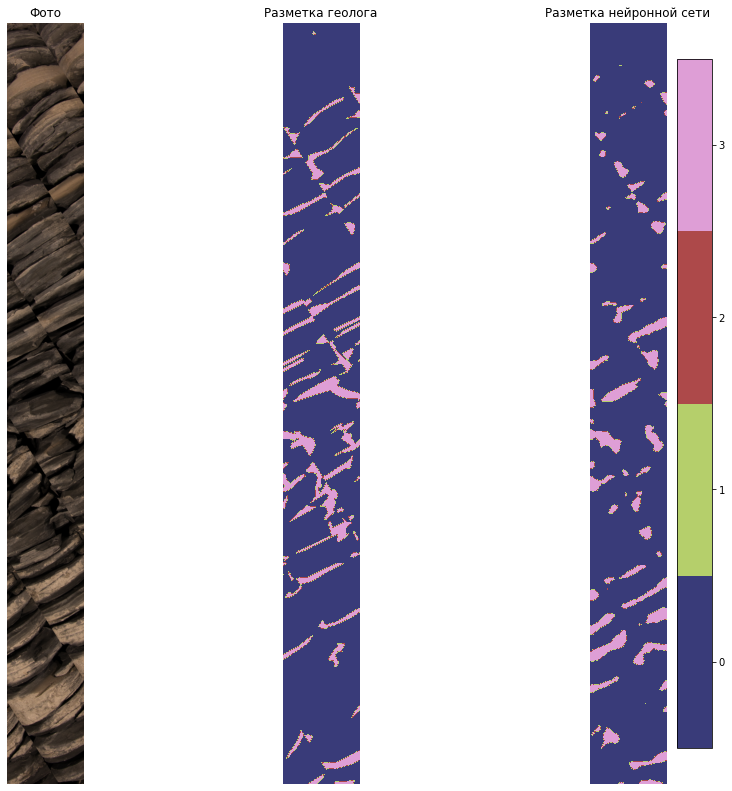

In [ ]:
model.eval()
show_mask(model, kf_train, 87)